In [124]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import transforms 

BATCH_SIZE = 100
NUM_EPOCHS = 3
NUM_ROUTING_ITERATIONS = 3
USE_CUDA = False

# 读取mnist数据集

In [16]:
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=dataset_transform)
        test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=dataset_transform)
        
        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)        

# Model

In [17]:
def squash(v):
    epsilon = 0.00000001
    vector_norm = (v ** 2).sum(-1,keepdim = True) + epsilon
    output = vector_norm * v/((1. + vector_norm) * torch.sqrt(vector_norm))
    return output

## Convlayer

In [18]:
#第一层，使用普通卷积得到基础特征
#(batch,28,28,1)
class Convlayer(nn.Module):
    def __init__(self,in_channels = 1,out_channels = 256,kernel_size = 9):
        super(Convlayer, self).__init__()
        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=kernel_size,
                              stride = 1)
    def forward(self,x):
        #(batch_size,20,20,256)
        return F.relu(self.conv(x))

## PrimaryCapslayer

In [19]:
class PrimaryCapslayer(nn.Module):
    def __init__(self,num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCapslayer,self).__init__()
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = in_channels,out_channels = out_channels,kernel_size = kernel_size,stride = 2,padding=0)
                                      for _ in range(num_capsules)])

    def forward(self,x):
        u = [capsule(x).view(x.size(0),-1,1) for capsule in self.capsules]
        #u:(batch_size,8,6,6,32)
        u = torch.cat(u,dim=-1)
        #u:(batch_size,1152,8)
        return squash(u)

## DigitCaps and Dynamic routing

In [112]:
class DigitCaps(nn.Module):
    def __init__(self,num_capsules = 10,num_routes = 32*6*6,in_channels = 8,out_channels = 16):
        super(DigitCaps,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        
        self.W = nn.Parameter(torch.randn(num_routes,num_capsules,out_channels,in_channels))
    
    def forward(self,x):
        u = x.unsqueeze(3)
        u = u.unsqueeze(2)
        #print("u.shape:",u.shape)
        #x:(batch_size,1152,1,8,1)
        #W:(1152,10,16,8)
        #W*x = (batch_size,1152,10,16,1)
        #W = self.W.unsqueeze(0)
        #print("w.shape",self.W.shape)
        u_hat = torch.matmul(self.W,u)
        #u_hat(batch_size, 1152, 10, 16, 1)
        u_hat = u_hat.squeeze(-1)
        #print("u_hat.shape",u_hat.shape)
        u_hat=u_hat.permute(0,2,1,3)
        
        b_ij = torch.zeros(u_hat.size(0),self.num_capsules,1,self.num_routes)
        if USE_CUDA:
            b_ij = b_ij.cuda()
            
        num_iterations = NUM_ROUTING_ITERATIONS
        for iteration in range(num_iterations):
            #print(b_ij.shape)
            c_ij = F.softmax(b_ij,-1)
            #print("u_hat.shape",u_hat.shape)
            #print("c_ij.shape:",c_ij.shape)
            s_j = torch.matmul(c_ij,u_hat)
            #print("s_j:",s_j.shape)
            v_j = squash(s_j)
            if iteration < num_iterations -1:
                a_ij = torch.matmul(v_j,u_hat.permute(0,1,3,2))
                b_ij = b_ij + a_ij
        v_j = v_j.permute(0,1,3,2).squeeze(-1)
        #v_j :(batch,10,16)
        return v_j

## Decoder

In [113]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    def forward(self,x,data):
        #x:(batch_size,10,16)
        classes = torch.sqrt((x**2).sum(2))
        classes = F.softmax(classes)
        #classes(batch_size,10)
        _,max_length_indices = classes.max(dim = 1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        #print(max_length_indices.shape)
        masked = masked.index_select(dim = 0,index=max_length_indices.data)
        
        masked = masked.unsqueeze(2)
        #print(masked.shape)
        #masked(100,10,1)
        reconstractions = self.reconstraction_layers((masked*x).view(x.size(0), -1))
        reconstractions = reconstractions.view(-1, 1, 28, 28)
        
        return reconstractions,masked

## CapsNet

In [119]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet,self).__init__()
        self.conv_layer = Convlayer()
        self.primarycaps_layer = PrimaryCapslayer()
        self.DigitCaps_layer = DigitCaps()
        self.decoder = Decoder()
        self.mse_loss = nn.MSELoss()
        
    def forward(self,data):
        data = self.conv_layer(data)
        data = self.primarycaps_layer(data)
        output = self.DigitCaps_layer(data)
        reconstractions,masked = self.decoder(output,data)
        return output ,reconstractions,masked
    
    def loss(self, data, x, target,reconstractions):
        loss1 = self.margin_loss(x, target)
        loss2 = self.reconstruction_loss(data,reconstractions)
        return  loss1,loss2
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2))
        #print("vc",v_c.shape)
        #(batch_size,10)
        left = F.relu(0.9 - v_c)**2
        right = F.relu(v_c - 0.1)**2
        labels = torch.sparse.torch.eye(10).index_select(dim=0, index=labels.data.cpu())
        #print(labels.shape)
        if USE_CUDA:
            labels = labels.cuda()
        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()
        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        #data(batch_size,1,28,28)
        #reconstractions(batch_size,1,28,28)
        loss = ((reconstructions.view(reconstructions.size(0), -1) - data.view(reconstructions.size(0), -1))**2).sum()/batch_size
        return loss * 0.0005

# Train

In [120]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = optim.Adam(capsule_net.parameters())

In [121]:
batch_size = BATCH_SIZE
mnist = Mnist(batch_size)
print("batch_size:",batch_size)
n_epochs = NUM_EPOCHS

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data,target) in enumerate(mnist.train_loader):
        if USE_CUDA:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        output,reconstractions,masked = capsule_net(data)
        loss1,loss2 = capsule_net.loss(data,output,target,reconstractions)
        
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if batch_id % 10 == 0:
            output = torch.sqrt((output**2).sum(dim=2, keepdim=True))
            output = output.squeeze(-1)
#             print(np.argmax(output.cpu().detach().numpy(),1))
#             print(target.cpu().detach())
            acc = sum(np.argmax(output.cpu().detach().numpy(),1) == target.data.cpu().numpy())/float(batch_size)
            print("Train Epoc:{} [{}/{} ({:.0f}%)]\tLoss1:{:.6f} \tLoss2: {:.6f} \ttrain accuracy:{:.4f}".format(
            epoch,batch_id * batch_size,len(mnist.train_loader.dataset),100. * batch_id / len(mnist.train_loader),loss1.item(),loss2.item(),acc))

    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):
    #         labels = torch.sparse.torch.eye(10).index_select(dim=0, index=labels.data.cpu())

            target = target.long()

            data, target = Variable(data), Variable(target)

            if USE_CUDA:
                data, target = data.cuda(), target.cuda()

            output,reconstractions,masked = capsule_net(data)
            loss1,loss2 = capsule_net.loss(data,output,target,reconstractions)
            loss = loss1 + loss2
    #         test_loss += loss.data[0]
            test_loss += loss.item()

            if batch_id % 100 == 0:
                output = torch.sqrt((output**2).sum(dim=2, keepdim=True))
                output = output.squeeze(-1)
                print("test accuracy:", sum(np.argmax(output.cpu().detach().numpy(),1) == target.data.cpu().numpy())/float(batch_size))

    
    print(test_loss / len(mnist.test_loader))

batch_size: 100


/home/haleypei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoc:0 [0/60000 (0%)]	Loss1:0.804218 	Loss2: 0.494283 	train accuracy:0.1100
Train Epoc:0 [1000/60000 (2%)]	Loss1:0.258713 	Loss2: 0.408298 	train accuracy:0.7600
Train Epoc:0 [2000/60000 (3%)]	Loss1:0.179331 	Loss2: 0.316093 	train accuracy:0.8700
Train Epoc:0 [3000/60000 (5%)]	Loss1:0.150295 	Loss2: 0.331899 	train accuracy:0.8900
Train Epoc:0 [4000/60000 (7%)]	Loss1:0.104187 	Loss2: 0.303006 	train accuracy:0.8900
Train Epoc:0 [5000/60000 (8%)]	Loss1:0.082361 	Loss2: 0.312958 	train accuracy:0.9900
Train Epoc:0 [6000/60000 (10%)]	Loss1:0.092698 	Loss2: 0.313303 	train accuracy:0.9200
Train Epoc:0 [7000/60000 (12%)]	Loss1:0.048352 	Loss2: 0.298465 	train accuracy:0.9700
Train Epoc:0 [8000/60000 (13%)]	Loss1:0.063867 	Loss2: 0.313722 	train accuracy:0.9400
Train Epoc:0 [9000/60000 (15%)]	Loss1:0.031852 	Loss2: 0.290149 	train accuracy:1.0000
Train Epoc:0 [10000/60000 (17%)]	Loss1:0.065567 	Loss2: 0.292407 	train accuracy:0.9100
Train Epoc:0 [11000/60000 (18%)]	Loss1:0.035340 	Lo

Train Epoc:1 [34000/60000 (57%)]	Loss1:0.019103 	Loss2: 0.238616 	train accuracy:0.9800
Train Epoc:1 [35000/60000 (58%)]	Loss1:0.010566 	Loss2: 0.246575 	train accuracy:1.0000
Train Epoc:1 [36000/60000 (60%)]	Loss1:0.003144 	Loss2: 0.250167 	train accuracy:1.0000
Train Epoc:1 [37000/60000 (62%)]	Loss1:0.012458 	Loss2: 0.244821 	train accuracy:0.9900
Train Epoc:1 [38000/60000 (63%)]	Loss1:0.009910 	Loss2: 0.244911 	train accuracy:0.9900
Train Epoc:1 [39000/60000 (65%)]	Loss1:0.015046 	Loss2: 0.233030 	train accuracy:0.9900
Train Epoc:1 [40000/60000 (67%)]	Loss1:0.010226 	Loss2: 0.239202 	train accuracy:0.9900
Train Epoc:1 [41000/60000 (68%)]	Loss1:0.021918 	Loss2: 0.242692 	train accuracy:0.9700
Train Epoc:1 [42000/60000 (70%)]	Loss1:0.009420 	Loss2: 0.239800 	train accuracy:0.9900
Train Epoc:1 [43000/60000 (72%)]	Loss1:0.013459 	Loss2: 0.246590 	train accuracy:0.9900
Train Epoc:1 [44000/60000 (73%)]	Loss1:0.009029 	Loss2: 0.243810 	train accuracy:0.9900
Train Epoc:1 [45000/60000 (75%)]

# 保存训练模型

In [122]:
torch.save(capsule_net.state_dict(), 'params sqe.pkl')

In [123]:
import os
model =  CapsNet()
model.load_state_dict(torch.load('params sqe.pkl'))
# if USE_CUDA:
#     model.cuda()
print(model)

CapsNet(
  (conv_layer): Convlayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primarycaps_layer): PrimaryCapslayer(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (DigitCaps_layer): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1024, out_features

# 重构效果

In [126]:
test_iter = iter(mnist.test_loader)
imgs,labels = next(test_iter)
print(imgs.shape)

torch.Size([100, 1, 28, 28])


In [127]:
x_test = torch.tensor(imgs[:50],dtype=torch.float)
y_test = torch.tensor(labels[:50],dtype=torch.long)

print(x_test.shape, y_test.shape)

torch.Size([50, 1, 28, 28]) torch.Size([50])


/home/haleypei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/haleypei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/haleypei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


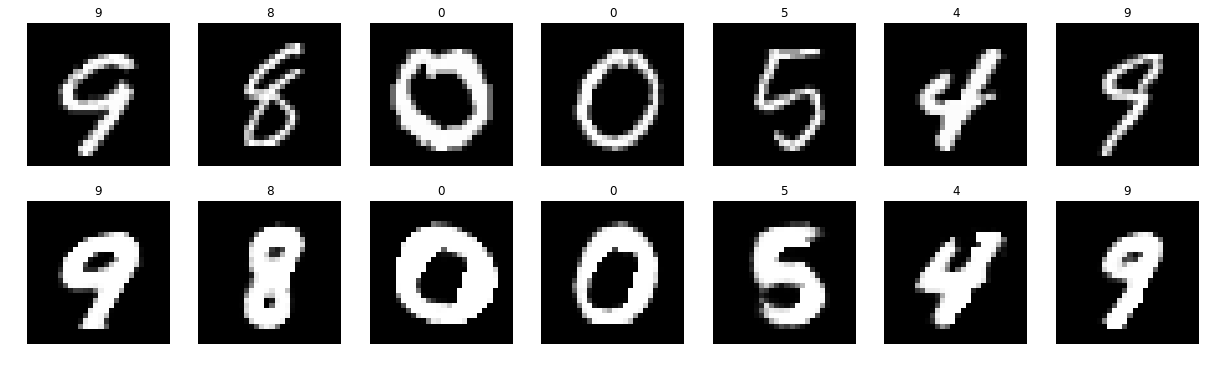

In [128]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

img_num = 7
k = random.randint(0,30)

imgs = x_test[k:img_num+k].cpu().numpy()
label = y_test[k:img_num+k].cpu().numpy()

y_true = torch.sparse.torch.eye(10).index_select(dim=0, index=y_test[k:img_num+k].cpu().data)
# y_true = y_true.cuda()
out,pred_imgs,masked = model(x_test[k:img_num+k])
pred_label = torch.sqrt(torch.sum(out*out, 2))

pred_imgs = pred_imgs.cpu().detach().numpy()
pred_label = pred_label.cpu().detach().numpy()
pred_label = np.argmax(pred_label,1)

plt.figure("test Image",figsize=(img_num*3,3*2))
for i in range(img_num):
    index = i
    img = imgs[index]
    title = label[index]
    img = img.reshape([28, 28])
    
    plt.subplot(2,img_num,i+1)
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
for i in range(img_num):
    index = i
    img = pred_imgs[index]
    plt.subplot(2,img_num,i+img_num+1)
    
    title = pred_label[index]
    img = img.reshape([28, 28])
    plt.imshow(img,cmap=plt.cm.gray)
    plt.axis('off') 
    plt.title(title)
    
filename = 'r1'+str(time.time())+'.jpg'
plt.savefig(filename)
plt.show()